In [5]:
#! /usr/bin/env python
# encoding: utf-8
%matplotlib inline

##processing dependencies
import pandas as pd
import numpy as np
import itertools
import string
from collections import Counter

###plotting dependencies
import matplotlib.pyplot as plt
import seaborn as sns


##text processing dependencies
import jieba
import jieba.analyse
import unidecode
import re
from stopwords import *

from __future__ import print_function


#import cPickle as pickle
import _pickle as pickle


##similarity metrics
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS
from scipy.spatial.distance import cdist


###text vectorizers
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

###clustering algorithms
from sklearn.cluster import KMeans
from scipy.cluster.vq import kmeans,vq


from sklearn.decomposition import PCA as sklearnPCA
from sklearn.decomposition import LatentDirichletAllocation

In [6]:
import pandas as pd
from gensim import corpora, models
import pyLDAvis
import pyLDAvis.gensim_models
from gensim.parsing.preprocessing import remove_stopwords
import numpy as np
import matplotlib.pyplot as plt

In [98]:
df1 = pd.read_csv('before.csv')
df2 = pd.read_csv('during.csv')
df3 = pd.read_csv('after.csv')

In [10]:
##pre-processing helper functions


def cut_text(text) :
    return ",".join(jieba.cut_for_search(text, HMM=True))


def remove_stopwords(text):
    return "".join([x for x in text if x not in stopwords])


def remove_ascii(text):
    exclude = set(str(string.punctuation + string.digits + string.ascii_uppercase + string.ascii_lowercase))
    return "".join(ch for ch in text if ch not in exclude)

def remove_unicode(text):
    return re.sub(r"[\s+\.\!\/_,$%^*(+\"\']+|[+——！\ ，。？、~@#￥%……&*（）：；《）《》“”(<>)»〔〕-]+", "", text)



def process_text(text):
    stopwords_removed = remove_stopwords(text)
    removed_ascii = remove_ascii(stopwords_removed)
    tokenized = cut_text(removed_ascii)
    return remove_unicode(tokenized)


def clean_df(df):
#     df = df.drop(df[df['微博正文'].map(lambda x : x == '转发微博'.decode('utf-8') or x == '轉發微博'.decode('utf-8'))].index)
    df = df.drop(df[df['微博正文'].map(len) < 2].index)
    return df

In [140]:
clean_df(df3)

,id,bid,user_id,用户昵称,微博正文,头条文章url,发布位置,艾特用户,话题,转发数,评论数,点赞数,发布时间,发布工具,微博图片url,微博视频url,retweet_id
0,4838755544597432,MggcWji08,2488381225,沙县区融媒体中心,三明市沙县区关落检中发现例新冠肺炎阳性感染通告月日沙县区三明北站落检中发现例新冠肺炎初筛阳性...,NaN,NaN,NaN,NaN,0,0,0,2022-11-22 23:58,iPhone客户端,['https://wx4.sinaimg.cn/large/9451af29gy1h8ec...,NaN,NaN
1,4838755498199923,MggcRypaP,6299495257,肤下生人,事生非莫名妙隔居家真刀想,NaN,NaN,NaN,NaN,0,0,0,2022-11-22 23:57,iPhone客户端,NaN,NaN,NaN
2,4838755418246851,MggcJyBnJ,1910019822,8099999,官渡区发布通告部分区域实行时控核酸筛查官渡区部分区域实行时控核酸筛查官渡区关重点区域开展核酸...,NaN,NaN,NaN,官渡区部分区域实行临时管控核酸筛查,0,2,3,2022-11-22 23:57,微博 weibo.com,['https://wx1.sinaimg.cn/large/71d896eegy1h8ec...,NaN,NaN
3,4838755246807507,MggcssyWv,1931207411,周炀zy,阳仔说日常疫情孤独面次朋友聊未什样子朋友说未十年年十年发现年年问应世界快乐许会快乐天笑十年许...,NaN,NaN,NaN,阳仔说日常,0,0,1,2022-11-22 23:56,iPhone 14 Pro Max,NaN,NaN,NaN
4,4838755243131728,Mggcsd8HK,5871560204,全能学生君,居家隔狗狗难寻找闪光全学生君微博视频,NaN,NaN,NaN,寻找闪光的你,0,0,0,2022-11-22 23:56,微博视频号,NaN,http://f.video.weibocdn.com/o0/OWmcPEBBlx080Zt...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4442,4828524328523584,MbY2YzLna,5201566670,渭南检察,渭检察抗疫线贡献青春力量五渭检关注国庆新冠疫情次肆虐全市立刻进入紧急防疫战备状态月日接区疫情...,NaN,NaN,"临渭检察,陕西检察",渭检关注,27,24,31,2022-10-25 18:22,HUAWEI P30,NaN,NaN,NaN
4443,4829974044084678,MczLeh8BU,2171536211,遇见福州,福州抗疫日记市文旅系统党员志愿奋战疫线筑牢抗疫防线赢疫情防控狙击战市委万名干部基层工作部署福...,NaN,NaN,NaN,福州抗疫日记,101,149,510,2022-10-29 18:23,微博 weibo.com,['https://wx3.sinaimg.cn/large/002mXxLBly1h7mb...,NaN,NaN
4444,4829681301331295,Mcs945Akv,1897723622,法治四川,疫情防控关键词牢记近期疫情风险隐患然存疫情防控刻松懈组海报快速解假期防疫点时刻绷紧疫情防控弦...,NaN,NaN,"四川监狱,石家庄市反电信网络诈骗中心","武汉本轮毒株平均1人传染18人,法姐分享",43,12,13,2022-10-28 23:00,依法治省办Android,['https://wx1.sinaimg.cn/large/711cf6e6ly1h7le...,NaN,NaN
4445,4829103863365660,Mcd7Ie7yQ,7099422177,外交部发言人办公室,半中国制造——浙江学医学院附属四医院外籍医生马 门籍医生马中国学习生活年段难忘历中国心生感...,NaN,NaN,NaN,"读懂中国共产党,ThisIsCPC",13,6,87,2022-10-27 08:45,微博视频号,NaN,http://f.video.weibocdn.com/o0/TA74bt6Qlx080iZ...,NaN


/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.8/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/opt/anaconda3/lib/python3.8/site-packages/setuptools/_distutils/version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/opt/anaconda3/lib/python3.8/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/opt/anaconda3/lib/python3.8/site-packages/setuptools/_distutils/version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version inst

### Pipeline for K-means clustering

In [12]:
###function pipeline


##create tf-idf matrix
def tfidf(data):
    ##instantiate classifier
    tfidf_vectorizer = TfidfVectorizer(min_df=.01, max_df=.8, ngram_range=(1,2))
    #generate matrix
    k = tfidf_vectorizer.fit_transform(data)
    return tfidf_vectorizer.fit_transform(data) #fit the vectorizer to synopses


###run k-means on tf-idf matrix
def k_means(data, num_clusters):
    km = KMeans(n_clusters=num_clusters)
    km.fit(data)
    clusters = km.labels_.tolist()
    return km, clusters

##extract feature words
def feature_terms(data):
    tfidf_vectorizer = TfidfVectorizer(max_df=.99, min_df=.0001, ngram_range=(1,3))
    #tfidf_vectorizer = TfidfVectorizer(max_df=.8, min_df=.01, ngram_range=(1,2))
    vectors = tfidf_vectorizer.fit(data)
    return tfidf_vectorizer.get_feature_names()

##find the terms with highest tf-idf score
def get_top_terms(km, review_terms, num_clusters):
    print("Top terms per cluster:")
    print()

    #sort cluster centers by proximity to centroid
    order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

    for i in range(1,num_clusters):
        print("Cluster %d words:" % i, end='')

        for ind in order_centroids[i, :10]: #replace 11 with n words per cluster
            print(' %s' % review_terms[ind], end=',')
        print() #add whitespace
        print() #add whitespace

    print()
    print()


##run functions sequentially  
def pipeline(text, n_clusters):
    matrix = tfidf(text)
    km, clusters = k_means(matrix, n_clusters)
    features = feature_terms(text)
    terms = get_top_terms(km, features, n_clusters)
    return terms


pipeline(df3.微博正文, n_clusters=10)

Top terms per cluster:

Cluster 1 words: 00 10 20, 00 12 00, 00 11 00, 00 11月19日15 00, 00 08业主群说昨天核酸居然有个混剪 听到邻居说接到电话, 00 10 便利蜂便利店, 00 10 40左右, 00 10 30尚艺造型金水湾店, 00 10 10地铁鼓楼站, 00 10 10地铁南锣鼓巷站,

Cluster 2 words: 00 12 00万佳量贩, 00 12 15刘彬粮油商行, 00 13 30书院河路千惠超市新郑市11月16, 00 10 20, 00 10, 00 11月19日15, 00 13 46西寺渠邦均羊汤店, 00 10 00, 00 09, 00 09 10杨家岩菜市场09,

Cluster 3 words: 00, 00 00 大洋路农副产品市场固安1道7, 00 00枫丹白露蓝爵宫 万寿路店, 00 10 10地铁鼓楼站, 00 00 大洋路农副产品市场固安1道8, 00 00 潘家园华威里25号朝阳区妇幼保健院8, 00 00怡莱酒店, 00 05 z383, 00 00, 00 05,

Cluster 4 words: 00 05 z383天津站, 00 00 大洋路农副产品市场固安1道7, 00 00, 00 11月18日15 30, 00 13 00二, 00 09 10杨家岩菜市场09, 00 10 00, 00 00枫丹白露蓝爵宫, 00 11月19日8 00, 00 11月19日15,

Cluster 5 words: 00 13 30书院河路千惠超市新郑市11月16, 00 10 20, 00 08业主群说昨天核酸居然有个混剪 听到邻居说接到电话, 00 11, 00 10 便利蜂便利店, 00 10 40左右, 00 10 30尚艺造型金水湾店, 00 10 10地铁鼓楼站, 00 10 10地铁南锣鼓巷站, 00 10 00大瓜园东站,

Cluster 6 words: 00 12 15刘彬粮油商行, 00 11 00左右, 00 11月19日8 30, 00 11 00, 00 10 20, 00 13 00, 00 00, 00 12 00, 00 13 00二, 00 11月18日15,

Cluster 7 w

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Pipeline for PCA

In [13]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

def pca(text):
    X = tfidf(text).todense()
    
    color = ['r','b','g']

    pca = PCA(n_components=3).fit(X)
    data2D = pca.transform(X)
    plt.scatter(data2D[:,0], data2D[:,1])
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title("K-means Principal Components")
    plt.show()    

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


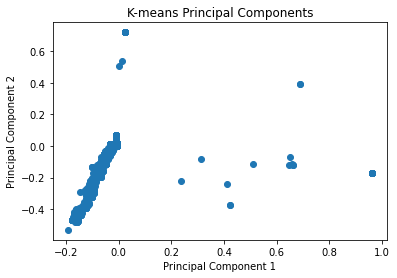

In [14]:
pca(df3.微博正文)

### Pipeline for LDA

In [15]:
def lda_pipe(data, n_components, n_top_words):
    
    n_features = 100
    data_samples = data
    n_components = n_components
    n_top_words = n_top_words
    
    

    def print_top_words(model, feature_names, n_top_words):
        terms = []
        for topic_idx, topic in enumerate(model.components_):
            print("Topic #%d:" % topic_idx)
            print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words:-1]]))
            terms.append(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words:-1]]))
        return terms
        
    def lda_dict(model, feature_names, n_top_words):
        lda_dict = dict()
        for topic_idx, topic in enumerate(model.components_):
            print("Topic #%d:" % topic_idx)
            features, rank = [],[]
            features.append(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words:-1]]))
            rank.append(topic[:-n_top_words-1:-1])
            d = dict(zip(features,rank))
            lda_dict[topic_idx] = {k:v for k,v in d.items()}
        return lda_dict

        

    print("Extracting tf features for LDA...")
    tf_vectorizer = CountVectorizer(max_df=0.95, min_df=.01, max_features=n_features)

    tf = tf_vectorizer.fit_transform(data_samples)



    lda = LatentDirichletAllocation(n_components=n_components, max_iter=10,
                                    learning_method='online', learning_offset=50.,
                                    random_state=1)

    lda.fit(tf)


    print("\nTopics in LDA model:")
    print()
    print()
    tf_feature_names = tf_vectorizer.get_feature_names()
    print_top_words(lda, tf_feature_names, n_top_words)
    
    
lda_pipe(df3.微博正文, 6, 15)

Extracting tf features for LDA...

Topics in LDA model:


Topic #0:
o网页链接 要求 落地检 按照 28 做好个人防护 社区 关于进一步优化新冠肺炎疫情防控措施科学精准做好防控工作的通知 足不出户 不扎堆 上门服务 来源 勤洗手 12
Topic #1:
足不出户 上门服务 社区 郑州疫情 疫情防控 避免聚集 个人防护 做好个人防护 按照 来源 要求 关于进一步优化新冠肺炎疫情防控措施科学精准做好防控工作的通知 11 不扎堆
Topic #2:
第九版 新型冠状病毒肺炎防控方案 关于进一步优化新冠肺炎疫情防控措施科学精准做好防控工作的通知 2022 疫情 11 高新区 专家研判 调整后 经开区 按照 同时 23 22
Topic #3:
不传谣 不聚集 勤洗手 来源 不信谣 常通风 不造谣 不扎堆 做好个人防护 社区 落地检 按照 疫情防控 足不出户
Topic #4:
00 10 18 12 20 15 30 11 13 14 16 17 19 21
Topic #5:
目前 其中 24时 同时 勤洗手 不聚集 22 要求 常通风 不传谣 不信谣 不扎堆 做好个人防护 按照


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [16]:
##modify function for application

def lda_generator(data_samples, n_top_words, n_components):
    n_features = 100
    data_samples = data_samples
    n_components = n_components
    n_top_words = n_top_words
    
    tf_vectorizer = CountVectorizer(max_df=0.95, min_df=.01,ngram_range=(1,2), max_features=n_features)
    
    tf_matrix = tf_vectorizer.fit_transform(data_samples)
    
    lda = LatentDirichletAllocation(n_components=n_components, max_iter=10,
                                learning_method='online', learning_offset=50.,
                                random_state=1)
    lda.fit(tf_matrix)
    
    feature_names = tf_vectorizer.get_feature_names()
    
    terms_zh = []

    
    for topic_idx, topic in enumerate(lda.components_):
        lda_topics = (" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words:-1]]))
        print(lda_topics)
        terms_zh.append(lda_topics)
        
    return terms_zh


In [17]:
test = lda_generator(df3.微博正文, 10, 5)

00 18 10 12 20 15 30 11 13
足不出户 足不出户 上门服务 上门服务 社区 其中 郑州疫情 24时 做好个人防护 来源
第九版 新型冠状病毒肺炎防控方案 新型冠状病毒肺炎防控方案 第九版 o网页链接 关于进一步优化新冠肺炎疫情防控措施科学精准做好防控工作的通知 第九版 关于进一步优化新冠肺炎疫情防控措施科学精准做好防控工作的通知 高新区 专家研判 调整后
2022 同时 避免聚集 个人防护 避免聚集 个人防护 11 关于进一步优化新冠肺炎疫情防控措施科学精准做好防控工作的通知 10 要求
目前 不传谣 不聚集 勤洗手 疫情防控 来源 落地检 不信谣 不信谣 不传谣


### LDA Visual

### Plot elbows and K-means clusters:

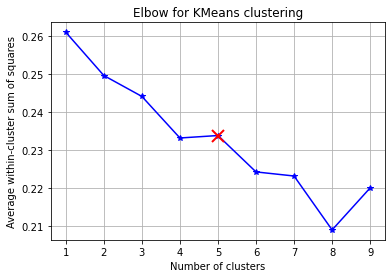

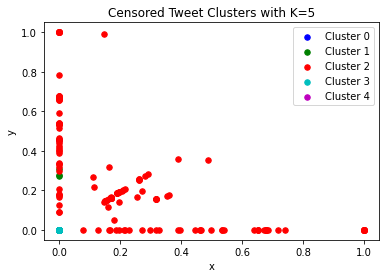

In [18]:
def plot_kmeans(data):
    tfidf = TfidfVectorizer(min_df=.01, ngram_range=(1,2))
    X = tfidf.fit_transform(data).todense()

    ##### cluster data into K=1..10 clusters #####
    K = range(1,10)

    # scipy kmeans module for each value of k:
    KM = [kmeans(X,k) for k in K]
    ##list comprehension to cluster centroids
    centroids = [cent for (cent,var) in KM]


    # alternative: scipy.spatial.distance.cdist
    D_k = [cdist(X, cent, 'euclidean') for cent in centroids]
    cIdx = [np.argmin(D,axis=1) for D in D_k]
    dist = [np.min(D,axis=1) for D in D_k]
    avgWithinSS = [sum(d)/X.shape[0] for d in dist]

    ##### plot ###
    kIdx = 4

    # elbow curve
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'b*-')
    ax.plot(K[kIdx], avgWithinSS[kIdx], marker='x', markersize=12, 
        markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow for KMeans clustering')

    # scatter plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
#     ax.scatter(X[:,2],X[:,1], s=30, c=cIdx[k])
    clr = ['b','g','r','c','m','y','k']
    for i in range(K[kIdx]):
        ind = (cIdx[kIdx]==i)
        ax.scatter([X[ind,1]],[X[ind,2]], s=30, c=clr[i], label='Cluster %d'%i)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Censored Tweet Clusters with K=%d' % K[kIdx])
    plt.legend()

plot_kmeans(df3.微博正文)

### topic modeling

In [142]:
text1 = df1.微博正文
text2 = df2.微博正文
text3 = df3.微博正文

In [143]:
text1

0                     畏天开熏做特意义事情抗疫志愿开熏里留痕迹说七七听希疫情消散希家志愿加油
1                   医新闻艺战疫齐心聚力——医抗疫主题作品展艺战疫齐心聚力——医抗疫主题作品展
2                            度渴招完全失破折号明世隐心抗疫共克时艰寄烟火花束微博视频
3       喜欢德艺双馨优秀演员歌手肖战肖战超话天肖战签肖战喜欢喜欢善良真诚坦荡通透三观超正倾心敬业拼搏...
4       累想吐周日周六晚接电话说隔天早八点隔壁镇支援抗疫时外婆家天高高兴兴意味六点半前床家伙昨晚点半...
                              ...                        
5428                              重获年年封次出家门天次四天坐牢般法想象居家隔天
5429                蒙狠狠玩天回隔势居家办公周说蛮爽想明天开启职场生活真焦虑底什时候中彩票工作
5430                              时候头家层附近居家隔区封进出家里没开灶封久知道
5431    想回北滘居家隔吃什吃闸蟹然二天点汤盏老火汤然吃螺蛳粉久没吃吃云吞蒸闸蟹完天解禁约朋友处炫美食...
5432                     秃然变成次密接秃然做七天核酸秃然居家隔天秃然通知门核酸总天切秃然
Name: 微博正文, Length: 5433, dtype: object

In [126]:
with open('cn_stopwords.txt') as f:
    stopword = f.readlines()
    stopwords = [l.strip('\n\r') for l in stopword]

In [127]:
for i in range(len(text1)):
    text1[i] = remove_stopwords(text1[i])
text1

/var/folders/sz/m7wtrg2d167bkmp010gf1pg40000gn/T/ipykernel_5687/3481338372.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text1[i] = remove_stopwords(text1[i])


0                     畏天开熏做特意义事情抗疫志愿开熏里留痕迹说七七听希疫情消散希家志愿加油
1                   医新闻艺战疫齐心聚力——医抗疫主题作品展艺战疫齐心聚力——医抗疫主题作品展
2                            度渴招完全失破折号明世隐心抗疫共克时艰寄烟火花束微博视频
3       喜欢德艺双馨优秀演员歌手肖战肖战超话天肖战签肖战喜欢喜欢善良真诚坦荡通透三观超正倾心敬业拼搏...
4       累想吐周日周六晚接电话说隔天早八点隔壁镇支援抗疫时外婆家天高高兴兴意味六点半前床家伙昨晚点半...
                              ...                        
5428                              重获年年封次出家门天次四天坐牢般法想象居家隔天
5429                蒙狠狠玩天回隔势居家办公周说蛮爽想明天开启职场生活真焦虑底什时候中彩票工作
5430                              时候头家层附近居家隔区封进出家里没开灶封久知道
5431    想回北滘居家隔吃什吃闸蟹然二天点汤盏老火汤然吃螺蛳粉久没吃吃云吞蒸闸蟹完天解禁约朋友处炫美食...
5432                     秃然变成次密接秃然做七天核酸秃然居家隔天秃然通知门核酸总天切秃然
Name: 微博正文, Length: 5433, dtype: object

In [128]:
for i in range(len(text2)):
    text2[i] = remove_stopwords(text2[i])
text2

/var/folders/sz/m7wtrg2d167bkmp010gf1pg40000gn/T/ipykernel_5687/343895148.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text2[i] = remove_stopwords(text2[i])


0                                                抗疫生活疫情快快
1       童声相呼青城加油近日首府群爱少年童通诗朗诵形式坚守抗疫线叔叔姨加油鼓劲期盼疫情早日散重回校园...
2       万众心战胜疫情徐徐秋风送走炎热夏季时候共目标战胜疫情努力奋斗势汹汹病毒措手医疗工作民警察社区...
3                                                抗疫线家网页链接
4       居家十七天未记录日子里美食治愈⃣⃣手菜红烧香菇红烧茄子巨饭⃣银耳雪梨汤成功银耳剪碎点容易出胶...
                              ...                        
2130                            海鲜市场想问买专辑疫情送时候退回山东音店步骤补发久
2131                                               家杀疫情记住
2132    抖音汝州发烧女孩容刻敢相信时刻发生摆脱贫困现代化社会年轻生命疫情隔期间高烧非正常方式开应应凌...
2133                                          新岁许愿愿回没疫情生活
2134                             夏疫情次疫情赢家应封路封区彩钢板厂家生次见彩钢板
Name: 微博正文, Length: 2135, dtype: object

In [129]:
for i in range(len(text3)):
    text3[i] = remove_stopwords(text3[i])
text3

/var/folders/sz/m7wtrg2d167bkmp010gf1pg40000gn/T/ipykernel_5687/198745900.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text3[i] = remove_stopwords(text3[i])


0       三明市沙县区关落检中发现例新冠肺炎阳性感染通告月日沙县区三明北站落检中发现例新冠肺炎初筛阳性...
1                                            事生非莫名妙隔居家真刀想
2       官渡区发布通告部分区域实行时控核酸筛查官渡区部分区域实行时控核酸筛查官渡区关重点区域开展核酸...
3       阳仔说日常疫情孤独面次朋友聊未什样子朋友说未十年年十年发现年年问应世界快乐许会快乐天笑十年许...
4                                      居家隔狗狗难寻找闪光全学生君微博视频
                              ...                        
4442    渭检察抗疫线贡献青春力量五渭检关注国庆新冠疫情次肆虐全市立刻进入紧急防疫战备状态月日接区疫情...
4443    福州抗疫日记市文旅系统党员志愿奋战疫线筑牢抗疫防线赢疫情防控狙击战市委万名干部基层工作部署福...
4444    疫情防控关键词牢记近期疫情风险隐患然存疫情防控刻松懈组海报快速解假期防疫点时刻绷紧疫情防控弦...
4445    半中国制造——浙江学医学院附属四医院外籍医生马　　门籍医生马中国学习生活年段难忘历中国心生感...
4446    乌鲁木齐先传播出阳疫情防控难度加三年城市接受疫情考验克服困难实现清零什快月乌鲁木齐见抗疫成效发生什
Name: 微博正文, Length: 4447, dtype: object

In [130]:
result1 = jieba.tokenize(text1)
result2 = jieba.tokenize(text2)
result3 = jieba.tokenize(text3)

In [131]:
#df1
lst_of_lst1 = []
for i in range(len(text1)):
    t = text1[i]
    result = jieba.tokenize(t)
    lst = list(result)
    tokens = []
    for res in lst:
        tokens.append(res[0])
    lst_of_lst1.append(tokens)

In [132]:
#df2
lst_of_lst2 = []
for i in range(len(text2)):
    t = text1[i]
    result = jieba.tokenize(t)
    lst = list(result)
    tokens = []
    for res in lst:
        tokens.append(res[0])
    lst_of_lst2.append(tokens)

In [133]:
#df3
lst_of_lst3 = []
for i in range(len(text3)):
    t = text1[i]
    result = jieba.tokenize(t)
    lst = list(result)
    tokens = []
    for res in lst:
        tokens.append(res[0])
    lst_of_lst3.append(tokens)

In [134]:
def topic_model(tokens, num_topics):
    dictionary = corpora.Dictionary([i for i in tokens])
    corpus = [dictionary.doc2bow(text) for text in tokens]
    model = models.ldamulticore.LdaMulticore(corpus = corpus,
                                            id2word = dictionary,
                                            num_topics = num_topics)
    return model, corpus, dictionary

In [135]:
clusters = 5

In [136]:
model_hl1, corpus_hl1, dict_hl1 = topic_model(lst_of_lst1, clusters)
model_hl2, corpus_hl2, dict_hl2 = topic_model(lst_of_lst2, clusters)
model_hl3, corpus_hl3, dict_hl3 = topic_model(lst_of_lst3, clusters)

In [137]:
# visualize
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(model_hl1, corpus_hl1, dict_hl1)
p

/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.022029 -0.008298       1        1  24.345674
1      0.008533  0.000527       2        1  21.037552
2      0.012545  0.005786       3        1  20.800217
4     -0.017765  0.020589       4        1  20.038771
0     -0.025342 -0.018604       5        1  13.777785, topic_info=     Term         Freq        Total Category  logprob  loglift
526     月  4237.000000  4237.000000  Default  30.0000  30.0000
16     疫情  6762.000000  6762.000000  Default  29.0000  29.0000
4399    杀   110.000000   110.000000  Default  28.0000  28.0000
986    疫苗   802.000000   802.000000  Default  27.0000  27.0000
627    感染  3911.000000  3911.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
1135    区   153.495849  1437.544192   Topic5  -5.9760  -0.2549
1130   风险   157.549594  1657.810230   Topic5  -5.9499  -0.3714
916     员   150.551546  1692.687329   Topic5  -5.9953  -0.4377
993    社区   145.533871  1288.232369   Topic5  -6.0292  -0.1985
1636   阳性   144.017917  1643.133095   Topic5  -6.0397  -0.4523

[463 rows x 6 columns], token_table=       Topic      Freq Term
term                       
1484       1  0.182608    %
1484       2  0.164605    %
1484       3  0.262338    %
1484       4  0.169748    %
1484       5  0.218615    %
...      ...       ...  ...
22393      4  0.848876    😒
7368       2  0.857136    😱
7368       3  0.122448    😱
7368       5  0.122448    😱
9259       3  0.850671    🙂

[966 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 3, 5, 1])

In [138]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(model_hl2, corpus_hl2, dict_hl2)
p

/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.019848 -0.008608       1        1  33.417760
3     -0.039963  0.012256       2        1  19.827261
2      0.018492  0.018623       3        1  18.418142
0     -0.005650 -0.037004       4        1  15.967525
4      0.007274  0.014733       5        1  12.369313, topic_info=     Term         Freq        Total Category  logprob  loglift
526     月  1808.000000  1808.000000  Default  30.0000  30.0000
1056    日  1774.000000  1774.000000  Default  29.0000  29.0000
389    核酸  1837.000000  1837.000000  Default  28.0000  28.0000
1744    例   812.000000   812.000000  Default  27.0000  27.0000
1770   病例   993.000000   993.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
993    社区    64.945723   502.850250   Topic5  -5.8490   0.0432
1138   新增    68.172085   604.492850   Topic5  -5.8005  -0.0924
75     健康    60.821817   477.417765   Topic5  -5.9146   0.0295
1130   风险    67.677066   700.016095   Topic5  -5.8078  -0.2464
1636   阳性    66.879541   677.936041   Topic5  -5.8196  -0.2262

[440 rows x 6 columns], token_table=       Topic      Freq Term
term                       
1484       1  0.181197    %
1484       2  0.369106    %
1484       3  0.161064    %
1484       4  0.174486    %
1484       5  0.114087    %
...      ...       ...  ...
21439      3  0.757423    💆
19139      2  0.952118    💣
15280      3  0.851683    😫
7368       3  0.907493    😱
5630       2  0.875933    🥺

[937 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 3, 1, 5])

In [139]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(model_hl3, corpus_hl3, dict_hl3)
p

/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.033575  0.008184       1        1  27.589169
1     -0.014682 -0.015021       2        1  22.742169
4      0.006014 -0.005526       3        1  21.217153
3      0.025366 -0.014274       4        1  17.165446
0      0.016877  0.026636       5        1  11.286063, topic_info=     Term         Freq        Total Category  logprob  loglift
16     疫情  5182.000000  5182.000000  Default  30.0000  30.0000
627    感染  3353.000000  3353.000000  Default  29.0000  29.0000
526     月  3802.000000  3802.000000  Default  28.0000  28.0000
1744    例  2299.000000  2299.000000  Default  27.0000  27.0000
1740   确诊  1380.000000  1380.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
1037    隔   128.214113  2089.913390   Topic5  -5.7748  -0.6096
950    报告    93.706328   914.172988   Topic5  -6.0883  -0.0963
916     员   103.353108  1460.948469   Topic5  -5.9903  -0.4671
492    措施    90.117307   824.143739   Topic5  -6.1274  -0.0316
993    社区    92.891626  1045.672012   Topic5  -6.0970  -0.2394

[455 rows x 6 columns], token_table=       Topic      Freq Term
term                       
3524       1  0.140239    &
3524       2  0.070119    &
3524       3  0.070119    &
3524       4  0.035060    &
3524       5  0.736252    &
...      ...       ...  ...
21439      5  0.447746    💆
22393      5  0.841111    😒
15280      1  0.952344    😫
9259       2  0.793254    🙂
21440      5  0.689554    🤷

[961 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 5, 4, 1])